In [1]:
import meep as mp
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Video
from scipy.constants import pi, c
from scipy.signal import hilbert, find_peaks
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [2]:
plt.rcParams['figure.figsize'] = [4,3]
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300

plt.rc('font', family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')

In [3]:
#Define conversion functions/factors to get to/from meep units and kms
#Length factor to transform lengths in kms
l_unit = 1e-6 #1 um
t_unit = l_unit/c #time unit is length/c

#multiplicative constants to convert frequencies from meep to kms hertz
freq_unit = c/l_unit

print("1 meep Length unit is", l_unit*1e+6, "um")
print("1 meep Time unit is", t_unit*1e+15, "fs")
print("1 meep Frequency unit is", freq_unit*1e-12, "THz")

1 meep Length unit is 1.0 um
1 meep Time unit is 3.3356409519815204 fs
1 meep Frequency unit is 299.792458 THz


# Resolution

In [4]:
#courant factor
S = 0.5

#resolution is number of pixels per meep unit
resolution = 10

#resolutions in meep units
space_res = 1/resolution
time_res = space_res*S

print("Pixel per unit: ", resolution)

print("Space resolution [meep]: ", space_res)
print("Time resolution [meep]: ", time_res)

print("Space resolution [um]: ", space_res*l_unit*1e+6)
print("Time resolution [fs]: ", time_res*t_unit*1e+15)

time_freq = 1/time_res
print("Time sampling frequency [meep]: ", time_freq)
print("Nyqvist frequency [meep]: ", time_freq/2)

Pixel per unit:  10
Space resolution [meep]:  0.1
Time resolution [meep]:  0.05
Space resolution [um]:  0.09999999999999999
Time resolution [fs]:  0.16678204759907606
Time sampling frequency [meep]:  20.0
Nyqvist frequency [meep]:  10.0


# Geometry Definition
Cell

In [5]:
#define cell size and resolution
#Cell size is in meep units
#center is in (0,0), ranges in x=(-sx/2,sx/2), y=(-sy/2,sy/2)
sx = 120
sy = 32

cell = mp.Vector3(sx, sy)

#boundary conditions thickness
pml_thickness = 2.0

#automatic positioning of boundaries
x_bound_up = sx/2 - pml_thickness
x_bound_low = -sx/2 + pml_thickness

y_bound_up = sy/2 - pml_thickness
y_bound_low = -sy/2 + pml_thickness

In [6]:
#materials refractive indexes
n_bgnd = 1
n_wvg = 3.55
n_ring = n_wvg

#Separating distance
d = 0.15

#Width properties
wvg_width = 1.6

ring_r = 7
ring_w = wvg_width

#Position properties
wvg_x = 0
wvg_y = -(wvg_width + d + ring_w*2 + ring_r*2)/2 + wvg_width/2

ring_x = 0
ring_y = wvg_y + wvg_width/2 + d + ring_w + ring_r


In [7]:
fund_resonance = 1/(2*pi*(ring_r+ring_w/2)*n_ring)
print("Predicted fundamental resonance at: ", fund_resonance)

Predicted fundamental resonance at:  0.005747740812275022


In [8]:
#calculate frequency regions for single-mode confined excitations
from math import ceil


NA = np.sqrt(n_wvg*n_wvg - n_bgnd*n_bgnd)
cut_off_freq = 1/(2*d)

upper_bound_freq = ceil(cut_off_freq/NA)

print("Predicted numerical aperture ", upper_bound_freq)
print("Predicted cut-off frequency: ", cut_off_freq)
print("Predicted upper frequency: ", upper_bound_freq)

Predicted numerical aperture  1
Predicted cut-off frequency:  3.3333333333333335
Predicted upper frequency:  1


Source

In [9]:
#Soure parameters
source_x = x_bound_low + 4
source_y = wvg_y

source_width = wvg_width

#Resonance number
m = 8

#note: df is not really the frequency sigma
#f_central = fund_resonance*m
#df = f_central

f_central = 0.048
df = 0.04

f_harm = f_central
df_harm = f_harm

print("#Source pulse frequency: fcent= ", f_central, " m.u., df= ",df, " m.u." )
print("#Source pulse frequency: fcent= ", f_central*freq_unit*1e-12, " THz, df= ",df*freq_unit*1e-12, " THz" )
print("#Source vacuum wavelength: lambda = ",  c/(f_central*freq_unit)*1e+6, "um, dlambda = ",c/(df*freq_unit)*1e+6,"um")
print("#Source wvg wavelength: lambda = ",  (c/n_wvg)/(f_central*freq_unit)*1e+6, "um")
print("#Source ring wavelength: lambda = ",  (c/n_ring)/(f_central*freq_unit)*1e+6, "um")

#Source pulse frequency: fcent=  0.048  m.u., df=  0.04  m.u.
#Source pulse frequency: fcent=  14.390037984  THz, df=  11.99169832  THz
#Source vacuum wavelength: lambda =  20.833333333333332 um, dlambda =  25.0 um
#Source wvg wavelength: lambda =  5.868544600938967 um
#Source ring wavelength: lambda =  5.868544600938967 um


Monitors

In [10]:

#Monitor parameters
#input
mon_1_x = source_x + 2
mon_1_y = wvg_y
mon_1_width = wvg_width + 4

#output
mon_2_x = x_bound_up - 4
mon_2_y = wvg_y
mon_2_width = wvg_width + 4

#number of sampling points in frequency for fourier transform of fields accumulated
N_freq = 300

#central frequency
f_mon_central = f_central
#width of sampled frequency band
df_mon = df


#Point for simulation termination condition
check_pt = mp.Vector3(mon_2_x - 0.2, mon_2_y)
check_pt_2 = mp.Vector3(ring_x, ring_y + ring_r + ring_w/2)
check_pt_3 = mp.Vector3(ring_x, ring_y - ring_r - ring_w/2)


# Harminv
Seek resonant frequencies

In [11]:
har_theta = pi/8
har_pt = mp.Vector3(ring_x + (ring_r + ring_w/2)*np.cos(har_theta), ring_y + (ring_r + ring_w/2)*np.sin(har_theta))

In [12]:
#Geometry objects
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(ring_x + ring_r + ring_w/2, ring_y),
                     size=mp.Vector3(ring_w, 0)),

                     mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(-(ring_x + ring_r + ring_w/2), ring_y),
                     size=mp.Vector3(ring_w, 0))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)
"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""

har = mp.Harminv(mp.Ez, har_pt, f_mon_central, df_mon)

#Simulate
mp.verbosity(1)
sim.run( mp.after_sources(har), until=200)
#mp.at_every(1,animate),
#animate.to_mp4(10, "Ez_Harminv.mp4")

-----------
Initializing structure...
time for choose_chunkdivision = 0.000348091 s
Working in 2D dimensions.
Computational cell is 120 x 32 x 0 with resolution 10
     cylinder, center = (0,0.875,0)
          radius 8.6, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.875,0)
          radius 7, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.687221 s
-----------


FloatProgress(value=0.0, description='0% done ', max=200.0)

Meep progress: 47.2/200.0 = 23.6% done in 4.0s, 12.9s to go
on time step 946 (time=47.3), 0.00423035 s/step
Meep progress: 92.95/200.0 = 46.5% done in 8.0s, 9.2s to go
on time step 1861 (time=93.05), 0.00437573 s/step
Meep progress: 144.35/200.0 = 72.2% done in 12.0s, 4.6s to go
on time step 2889 (time=144.45), 0.00389141 s/step
Meep progress: 198.95000000000002/200.0 = 99.5% done in 16.0s, 0.1s to go
on time step 3982 (time=199.1), 0.00366431 s/step
harminv0:, frequency, imag. freq., Q, |amp|, amplitude, error
harminv0:, 0.05212266315512544, -0.0003470800685321092, 75.08737591237316, 0.02876547413496005, 0.02359539642305136-0.016453260158646697i, 0.000283237884325146+0.0i
harminv0:, 0.06371941099710351, -0.00029863310678232595, 106.68510883414656, 0.03809087024991429, -0.03179385063167153+0.020977737208926157i, 0.00018436105480785286+0.0i
run 0 finished at t = 200.0 (4000 timesteps)


In [13]:
#Video("Ez_Harminv.mp4")

In [14]:
har_freq = [m.freq for m in har.modes]
print(har_freq)

[0.05212266315512544, 0.06371941099710351]


# Normalization run

In [15]:
sim.reset_meep()
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))

geometry = [waveguide]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

#Simulate
mp.verbosity(1)
sim.run( until_after_sources = mp.stop_when_fields_decayed(100, mp.Ez, check_pt, 1e-3))


#Get Fourier-transformed fields of incident pulse
norm_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
norm_inc_flux = mp.get_fluxes(incident)

flux_freqs = mp.get_flux_freqs(tran)

-----------
Initializing structure...
time for choose_chunkdivision = 0.00022316 s
Working in 2D dimensions.
Computational cell is 120 x 32 x 0 with resolution 10
     block, center = (0,-8.675,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
time for set_epsilon = 0.520524 s
-----------
on time step 999 (time=49.95), 0.00400479 s/step
on time step 1955 (time=97.75), 0.00418691 s/step
field decay(t = 100.05000000000001): 6.651899524834937e-86 / 6.651899524834937e-86 = 1.0
on time step 2946 (time=147.3), 0.00403797 s/step
field decay(t = 200.10000000000002): 7.744300422611019e-08 / 7.744300422611019e-08 = 1.0
on time step 4079 (time=203.95), 0.00353142 s/step
on time step 5191 (time=259.55), 0.00359739 s/step
field decay(t = 300.15000000000003): 8.651364423178207e-06 / 8.651364423178207e-06 = 1.0
on time step 6321 (time=316.05), 0.00354191 s/step
on time step 7450 (time=372.5), 0.00354

# Broad run

In [16]:
sim.reset_meep()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000249863 s
Working in 2D dimensions.
Computational cell is 120 x 32 x 0 with resolution 10
     block, center = (0,-8.675,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.875,0)
          radius 8.6, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.875,0)
          radius 7, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.716085 s
-----------
on time step 957 (time=47.85), 0.00418278 s/step
on time step 1835 (time=91.75), 0.00456095 s/step
on time step 2916 (time=145.8), 0.0037031 s/step
field decay(t = 150.05): 4.35612141719441e-09 / 4.35612141719441e-09 = 1.0
on time step 4024 (time=201.2), 0.00361047 s/step
on time step 5150 (time=257.5)

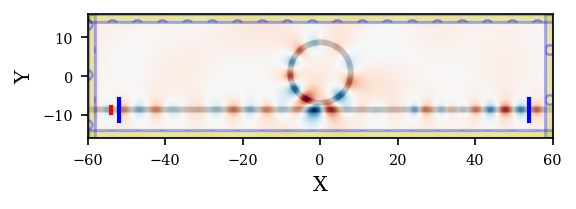

<Figure size 600x450 with 0 Axes>

In [17]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [waveguide,
            ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central, fwidth=df*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central, df_mon, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central, df_mon, N_freq, tran_fr)

"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""

#Simulate
mp.verbosity(1)
sim.run( until_after_sources = mp.stop_when_fields_decayed(150, mp.Ez, check_pt, 3e-3))

#mp.at_every(1,animate),
#animate.to_mp4(10, "Ez_broad.mp4")

sim.plot2D(fields=mp.Ez,
           field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'none'},
           boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
plt.show()
plt.savefig('img/geometry.png')

In [18]:
#Video("Ez_broad.mp4")

In [19]:

#Get Fourier-transformed fields of incident pulse
ring_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
ring_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
ring_inc_flux = mp.get_fluxes(incident)

ring_freqs = mp.get_flux_freqs(tran)

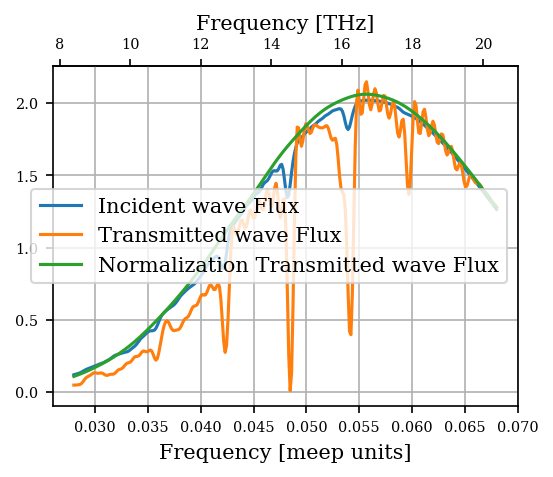

In [20]:
plt.plot(flux_freqs, ring_inc_flux, label="Incident wave Flux")
plt.plot(flux_freqs, ring_tran_flux, label="Transmitted wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="Normalization Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')


#for xc in har_freq:
    #plt.axvline(x=xc, color='k', linestyle='--')

plt.legend()
plt.grid()

plt.savefig('img/broadspectrum.png')

In [21]:
Tr = np.array(ring_tran_flux)/np.array(norm_tran_flux)

In [22]:
freq_res_main = flux_freqs[np.argmin(Tr)]
print(freq_res_main)

0.04846822742474917


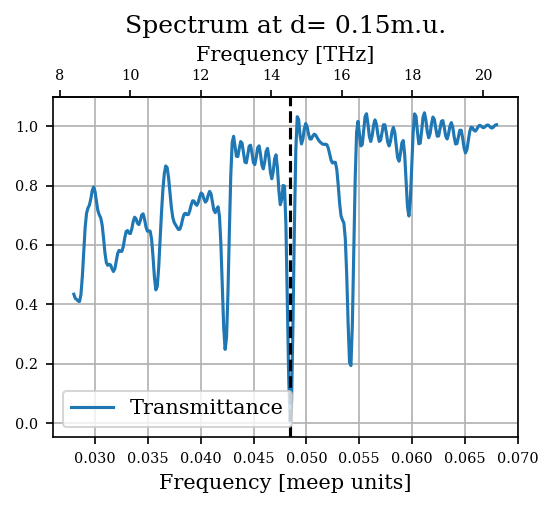

In [23]:
plt.plot(flux_freqs, Tr, label="Transmittance")

plt.title('Spectrum at d= '+"{:.2f}".format(d)+"m.u.")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')


#for xc in har_freq:
    #plt.axvline(x=xc, color='k', linestyle='--')

plt.axvline(x=freq_res_main, color='k', linestyle='--')

plt.legend()
plt.grid()

plt.savefig('img/broadtransmittance.png')

In [24]:
sim.reset_meep()

# Focused simulation

In [25]:
#Resonance values
f_central_resonance = freq_res_main
df_resonance = 0.005

#central frequency
f_mon_central_resonance = f_central_resonance
#width of sampled frequency band
df_mon_resonance = df_resonance

#predicted wavelength
pred_wvlght = 1/(f_central_resonance*n_ring)

print("Predicted wavelength: ",pred_wvlght)

Predicted wavelength:  5.811851512053274


In [26]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [waveguide,
            ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.GaussianSource(frequency=f_central_resonance, fwidth=df_resonance*3),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)

# Flux Monitor 1
incident_fr = mp.FluxRegion(center=mp.Vector3(mon_1_x, mon_1_y), size=mp.Vector3(0, mon_1_width, 0))
incident = sim.add_flux(f_mon_central_resonance, df_mon_resonance, N_freq, incident_fr)

# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(f_mon_central_resonance, df_mon_resonance, N_freq, tran_fr)

"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""

#Simulate
mp.verbosity(1)
sim.run( until_after_sources = mp.stop_when_fields_decayed(200, mp.Ez, check_pt, 1e-3))
#mp.at_every(1,animate),

#animate.to_mp4(10, "Ez_focused.mp4")

-----------
Initializing structure...
time for choose_chunkdivision = 0.000449896 s
Working in 2D dimensions.
Computational cell is 120 x 32 x 0 with resolution 10
     block, center = (0,-8.675,0)
          size (1e+20,1.6,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.875,0)
          radius 8.6, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (12.6025,12.6025,12.6025)
     cylinder, center = (0,0.875,0)
          radius 7, height 1e+20, axis (0, 0, 1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.759325 s
-----------
on time step 731 (time=36.55), 0.00548033 s/step
on time step 1256 (time=62.8), 0.00761979 s/step
on time step 1940 (time=97), 0.00585155 s/step
on time step 2891 (time=144.55), 0.00420661 s/step
on time step 3823 (time=191.15), 0.00429252 s/step
field decay(t = 200.05): 6.586162484995903e-15 / 6.58616

In [27]:
#Video("Ez_focused.mp4")

In [28]:

#Get Fourier-transformed fields of incident pulse
norm_incident_data = sim.get_flux_data(incident)

#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

#Get fluxes from fourier transformed incident fields
norm_inc_flux = mp.get_fluxes(incident)

flux_freqs = mp.get_flux_freqs(tran)

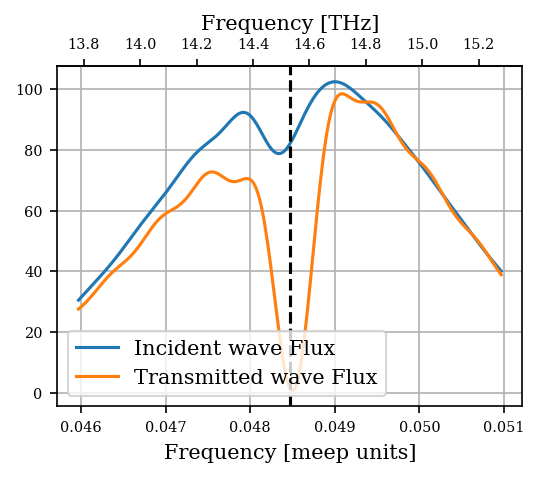

In [29]:
plt.plot(flux_freqs, norm_inc_flux, label="Incident wave Flux")
plt.plot(flux_freqs, norm_tran_flux, label="Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.axvline(x=freq_res_main, color='k', linestyle='--')


plt.legend()
plt.grid()

plt.savefig('img/focusedspectrum.png')

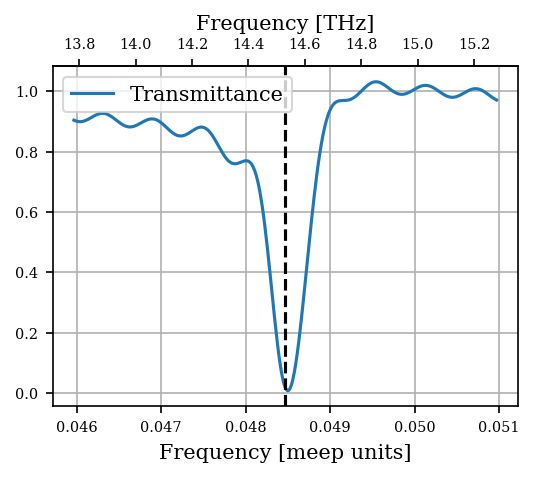

<Figure size 600x450 with 0 Axes>

In [30]:
Tr = np.array(norm_tran_flux)/np.array(norm_inc_flux)

plt.plot(flux_freqs, Tr, label="Transmittance")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.axvline(x=freq_res_main, color='k', linestyle='--')



plt.legend()
plt.grid()
plt.show()

plt.savefig('img/focusedtransmittance.png')

In [31]:
freq_res_main = flux_freqs[np.argmin(Tr)]
print("Resonance freqeuency: ", freq_res_main )


Resonance freqeuency:  0.048493311036789305


# $\Delta \phi$ calculation

In [32]:
sim.reset_meep()

In [33]:
run_time = 550

In [34]:
#Geometry objects
waveguide = mp.Block(mp.Vector3(mp.inf, wvg_width, mp.inf),
                    center = mp.Vector3(wvg_x, wvg_y),
                    material = mp.Medium(index=n_wvg))
ext_ring = mp.Cylinder(radius=ring_r+ring_w,
                    center=mp.Vector3(ring_x, ring_y),
                    material = mp.Medium(index=n_ring))
int_ring = mp.Cylinder(radius=ring_r,
                    center=mp.Vector3(ring_x, ring_y))

geometry = [waveguide,
            ext_ring,
            int_ring]

#define sources
#gaussian pulse with f_central and df
sources = [mp.Source(mp.ContinuousSource(frequency=freq_res_main, width=100),
                     component=mp.Ez,
                     center=mp.Vector3(source_x, source_y),
                     size=mp.Vector3(0, source_width))]

#define boundary conditions
pml_layers = [mp.PML(pml_thickness)]

#Instance simulation with chosen parameters
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    geometry=geometry,
                    resolution=resolution)


# Flux Monitor 2
tran_fr = mp.FluxRegion(center=mp.Vector3(mon_2_x, mon_2_y), size=mp.Vector3(0,mon_2_width,0))
tran = sim.add_flux(freq_res_main, df_mon, N_freq, tran_fr)
  
"""
animate = mp.Animate2D(sim,
                       fields=mp.Ez,
                       normalize=True,
                       realtime=False,
                       eps_parameters={'alpha':1, 'cmap':'RdBu', 'interpolation':'spline36'},
                       field_parameters={'alpha':0.8, 'cmap':'RdBu', 'interpolation':'spline36'},
                       boundary_parameters={'hatch':'o', 'linewidth':1.5, 'facecolor':'y', 'edgecolor':'b', 'alpha':0.3})
"""

#Simulate
mp.verbosity(0)
sim.run( until=run_time)
#mp.at_every(1,animate),
#animate.to_mp4(10, "Ez_phase.mp4")

FloatProgress(value=0.0, description='0% done ', max=550.0)

In [35]:
#Video("Ez_phase.mp4")

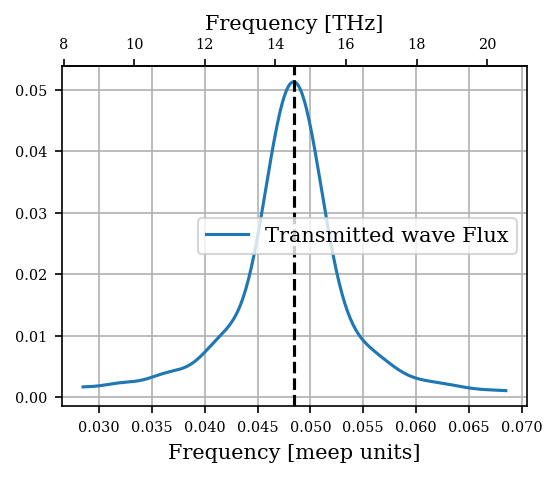

In [36]:
#Get fluxes from fourier transformed fields transmitted
norm_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(tran)

plt.plot(flux_freqs, norm_tran_flux, label="Transmitted wave Flux")

plt.xlabel("Frequency [meep units]")

ax = plt.gca()

def MU2THz(x):
    return x *freq_unit*1e-12


def THz2MU(x):
    return x /(freq_unit*1e-12)

secax = ax.secondary_xaxis('top', functions=(MU2THz, THz2MU))
secax.set_xlabel('Frequency [THz]')

plt.axvline(x=freq_res_main, color='k', linestyle='--')


plt.legend()
plt.grid()

In [37]:
ez_data_wvg = sim.get_array(center=mp.Vector3(0,wvg_y), size=mp.Vector3(sx, 0.001), component=mp.Ez)
print(ez_data_wvg.shape)

x = np.arange(-sx/2, sx/2, 1/resolution)

(1200, 2)


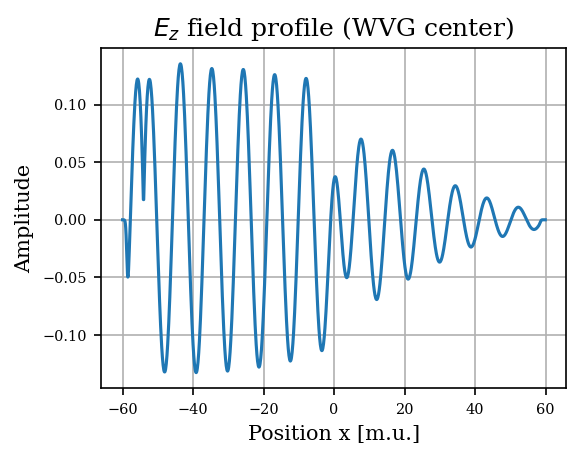

In [38]:
plt.figure()

plt.plot(x, ez_data_wvg[:,0])

plt.xlabel("Position x [m.u.]")
plt.ylabel("Amplitude")


plt.title(r"$E_z$ field profile (WVG center)")
plt.grid()

plt.savefig('img/Ezprofile.png')

## $\Delta \phi$ extraction

In [39]:
init_mask = (x>(source_x + 0.4))&(x<((-1)*(ring_r+ring_w)))

init_wave = ez_data_wvg[init_mask][:,0]
init_x = x[init_mask]

fin_mask = (x>(ring_r+ring_w))&(x<(x_bound_up-0.4))

fin_wave = ez_data_wvg[fin_mask][:,0]
fin_x = x[fin_mask]

wv_lngth = 1/(f_central_resonance*n_wvg)
wv_vector = 2*pi/(wv_lngth)


In [40]:
init_peaks, _ = find_peaks(init_wave, height=0.0)
fin_peaks, _ = find_peaks(fin_wave, height=0.0)

init_x_peaks = init_x[init_peaks]
fin_x_peaks = fin_x[fin_peaks]

init_spacings = np.diff(init_x[init_peaks])
fin_spacings = np.diff(fin_x[fin_peaks])

print(init_spacings)
print(fin_spacings)

[8.8 8.9 8.9 8.9]
[8.9 8.9 8.9 8.9]


## Linear fit to extract wavelength

In [41]:
def func_linear(m, k, phi):
    return (m*2*pi + pi/2 -phi)/k

popt_init, pcov_init = curve_fit(func_linear, [i[0] for i in enumerate(init_x_peaks)], init_x_peaks)

k_fit_init = popt_init[0]
phi_init = popt_init[1]%(2*pi)

print("K_init: ",k_fit_init," phi_init:", phi_init)
print("wavelength_init: ",2*pi/k_fit_init)


popt_fin, pcov_fin = curve_fit(func_linear, [i[0] for i in enumerate(fin_x_peaks)], fin_x_peaks)

k_fit_fin = popt_fin[0]
phi_fin = popt_fin[1]%(2*pi)

print("K_fin: ",k_fit_fin," phi_fin:", phi_fin)
print("wavelength_fin: ",2*pi/k_fit_fin)


DeltaPhi = (phi_fin - phi_init)%(2*pi)
print("Delta Phi:", DeltaPhi, "Pis:",DeltaPhi/pi, ", Degrees: ",DeltaPhi*360/(2*pi))


K_init:  0.7075659129633005  phi_init: 0.9764409596912671
wavelength_init:  8.88000000009254
K_fin:  0.7059758772111795  phi_fin: 2.4179673794477203
wavelength_fin:  8.900000000000126
Delta Phi: 1.4415264197564532 Pis: 0.4588521106036039 , Degrees:  82.59337990864871


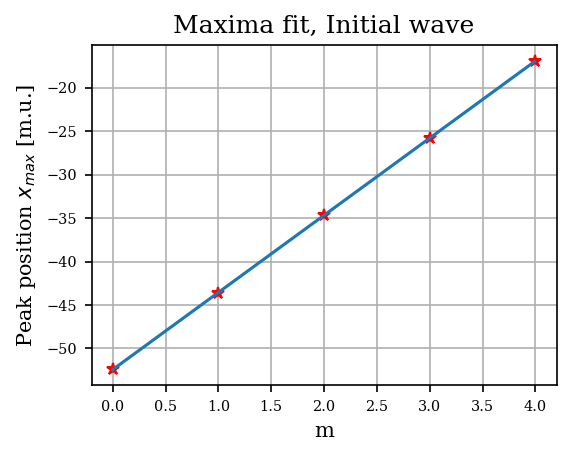

In [42]:
dummy_m_init = np.arange(np.amin([i[0] for i in enumerate(init_x_peaks)]), np.amax([i[0] for i in enumerate(init_x_peaks)]), 0.01)

plt.xlabel("m")
plt.ylabel("Peak position $x_{max}$ [m.u.]")
plt.title("Maxima fit, Initial wave")
plt.plot([i[0] for i in enumerate(init_x_peaks)],init_x_peaks ,"r*")
plt.plot(dummy_m_init, func_linear(dummy_m_init, *popt_init), label=r"linear fit")

plt.grid()

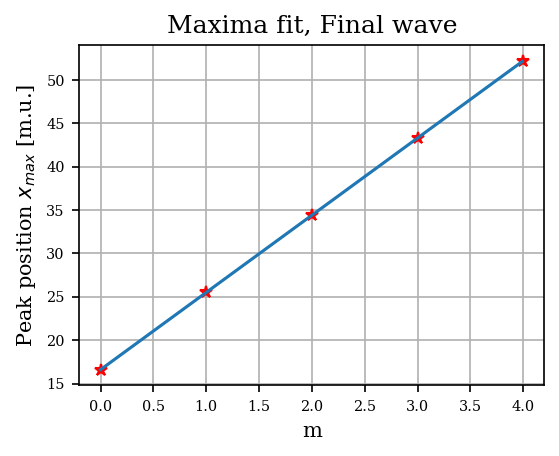

In [43]:
dummy_m_fin = np.arange(np.amin([i[0] for i in enumerate(fin_x_peaks)]), np.amax([i[0] for i in enumerate(fin_x_peaks)]), 0.01)

plt.title("Maxima fit, Final wave")
plt.xlabel("m")
plt.ylabel("Peak position $x_{max}$ [m.u.]")
plt.plot([i[0] for i in enumerate(fin_x_peaks)],fin_x_peaks,"r*" )
plt.plot(dummy_m_fin, func_linear(dummy_m_fin, *popt_fin), label=r"linear fit")

plt.grid()

In [44]:
def func_1(x, k, phi):
    return np.amax(init_wave)*np.sin(k*x + phi)

def func_2(x, k, phi):
    return np.amax(fin_wave)*np.sin(k*x + phi)

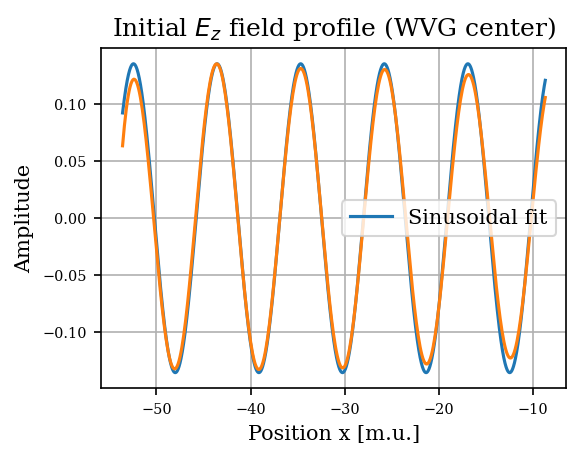

In [45]:
plt.figure()

dummy_x_init = np.arange(np.amin(init_x), np.amax(init_x), 0.01)

plt.plot(dummy_x_init, func_1(dummy_x_init, *popt_init), label=r"Sinusoidal fit")
plt.plot(init_x, init_wave)

plt.xlabel("Position x [m.u.]")
plt.ylabel("Amplitude")

plt.title(r"Initial $E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

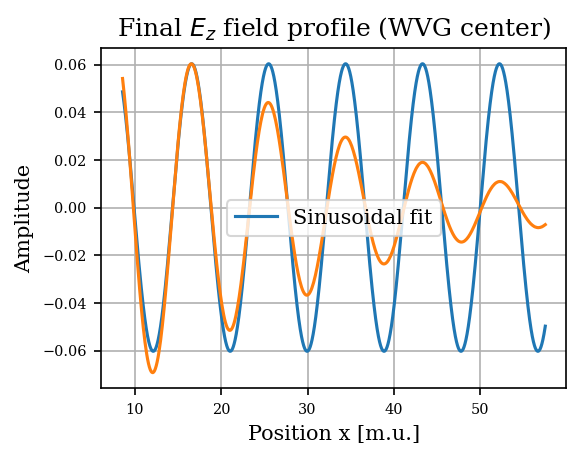

In [46]:
plt.figure()

plt.xlabel("Position x [m.u.]")
plt.ylabel("Amplitude")


dummy_x_fin = np.arange(np.amin(fin_x), np.amax(fin_x), 0.01)

plt.plot(dummy_x_fin, func_2(dummy_x_fin, *popt_fin), label=r"Sinusoidal fit")
plt.plot(fin_x, fin_wave)

plt.title(r"Final $E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

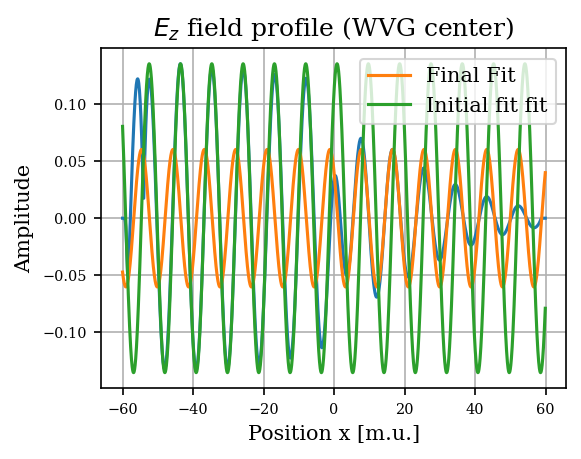

In [47]:
plt.figure()

plt.xlabel("Position x [m.u.]")
plt.ylabel("Amplitude")

dummy_x = np.arange(np.amin(x), np.amax(x), 0.01)

plt.plot(x, ez_data_wvg[:,0])
plt.plot(dummy_x, func_2(dummy_x, *popt_fin), label=r"Final Fit")
plt.plot(dummy_x, func_1(dummy_x, *popt_init), label=r"Initial fit fit")


plt.title(r"$E_z$ field profile (WVG center)")
plt.legend()
plt.grid()

plt.savefig('img/Ezfit.png')

# Notes

## Notch attenuation
## Resolution 20
0.05 0.2

0.1 0.3

0.2 0.7

0.3 0.8

0.5 0.9

0.6 0.96

## Resolution 40
0.05 0.2

# Resonances
d, f, Dphi

0.05, 0.14025, 0.1359pi

0.3, 0.14065, 0.135964pi

Ok so we are in undercoupling probably, and this is why we get values only around 0 (i think)
resonances until now: 0.14, 0.1298

Good option, does pi/2 shift (likely in critical):

r = 8, m=8, width=1.6